In [1]:
pip install pandas openpyxl


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas scikit-learn matplotlib seaborn xgboost lightgbm catboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

# Load the dataset
file_path = r'C:\Users\ANISH\Desktop\dissertation\proposal\seawatchers\extracted_data\final.xlsx'
xls = pd.ExcelFile(file_path)

# Load individual sheets
occurrence_df = pd.read_excel(xls, 'occurrence')
extended_df = pd.read_excel(xls, 'extendedmeasurementorfact')
event_df = pd.read_excel(xls, 'event')

# Step 1: Filter for Coral Alert! from occurrence sheet
coral_alert_occurrences = occurrence_df[occurrence_df['collectionCode'] == 'Coral Alert!']

# Step 2: Merge the filtered Coral Alert! data with the extendedmeasurementorfact sheet using occurrenceID
merged_occurrence_extended = extended_df.merge(coral_alert_occurrences[['id', 'eventID']], left_on='occurrenceID', right_on='id', how='inner')

# Step 3: Merge with the event sheet to bring max depth, min depth, latitude, and longitude
merged_final = merged_occurrence_extended.merge(event_df[['id', 'maximumDepthInMeters', 'minimumDepthInMeters', 'decimalLatitude', 'decimalLongitude']],
                                                left_on='eventID', right_on='id', how='left')

# Step 4: Filter rows where measurementType is "Total non-affected no injuries coral colonies"
filtered_data = merged_final[merged_final['measurementType'] == 'Total non-affected no injuries coral colonies']

# Step 5: Add additional relevant attributes (e.g., invasive algae, human activities)
relevant_attributes = [
    'Invasive algae', 
    'Evidence of anchoring, mass mortality, excessive algal covering, dumping, water turbidity impact of Pen Shell',
    'Total mortality affected coral colonies',
    'Water temperature',
    'Extent of the algae-free zone',
    'Protected level of MPA'
]
additional_relevant_data = merged_final[merged_final['measurementType'].isin(relevant_attributes)]

# Step 6: Merge additional relevant data with filtered coral health data
final_dataset = pd.concat([filtered_data, additional_relevant_data])

# Step 7: Save the final dataset to an Excel file
output_file_path = r'C:\Users\ANISH\Desktop\merged_coral_health_dataset_12.xlsx'
final_dataset.to_excel(output_file_path, index=False)

# Output a message indicating that the dataset is saved
print(f"The final dataset has been saved as '{output_file_path}'.")


The final dataset has been saved as 'C:\Users\ANISH\Desktop\merged_coral_health_dataset_12.xlsx'. You can now manually review it.


In [4]:
import pandas as pd

# Load the dataset
file_path = r'C:\Users\ANISH\Desktop\merged_coral_health_dataset_12.xlsx'
data = pd.read_excel(file_path)

# Step 1: Drop unnecessary columns with mostly missing values
columns_to_drop = [
    'measurementValueID', 'measurementAccuracy', 'measurementDeterminedDate', 
    'measurementDeterminedBy', 'measurementMethod', 'measurementRemarks'
]
cleaned_data = data.drop(columns=columns_to_drop)

# Step 2: Handle missing values in 'measurementValue' and 'maximumDepthInMeters'
# Drop rows with missing 'measurementValue' since it's critical
cleaned_data = cleaned_data.dropna(subset=['measurementValue'])

# Fill missing 'maximumDepthInMeters' with the median depth without using inplace
median_depth = cleaned_data['maximumDepthInMeters'].median()
cleaned_data['maximumDepthInMeters'] = cleaned_data['maximumDepthInMeters'].fillna(median_depth)

# Step 3: Convert 'measurementValue' to numeric (ignore errors if any)

cleaned_data['measurementValue'] = pd.to_numeric(cleaned_data['measurementValue'], errors='coerce')

# Step 4: Ensure depth consistency (minimumDepth should not exceed maximumDepth)

cleaned_data = cleaned_data[cleaned_data['minimumDepthInMeters'] <= cleaned_data['maximumDepthInMeters']]

# Step 5: Save the cleaned data to a new Excel file
cleaned_data.to_excel(r'C:\Users\ANISH\Desktop\cleaned_coral_health_dataset_12.xlsx', index=False)

print("Data cleaning complete. The cleaned dataset is saved as 'cleaned_coral_health_dataset_12.xlsx'.")


Data cleaning complete. The cleaned dataset is saved as 'cleaned_coral_health_dataset_12.xlsx'.


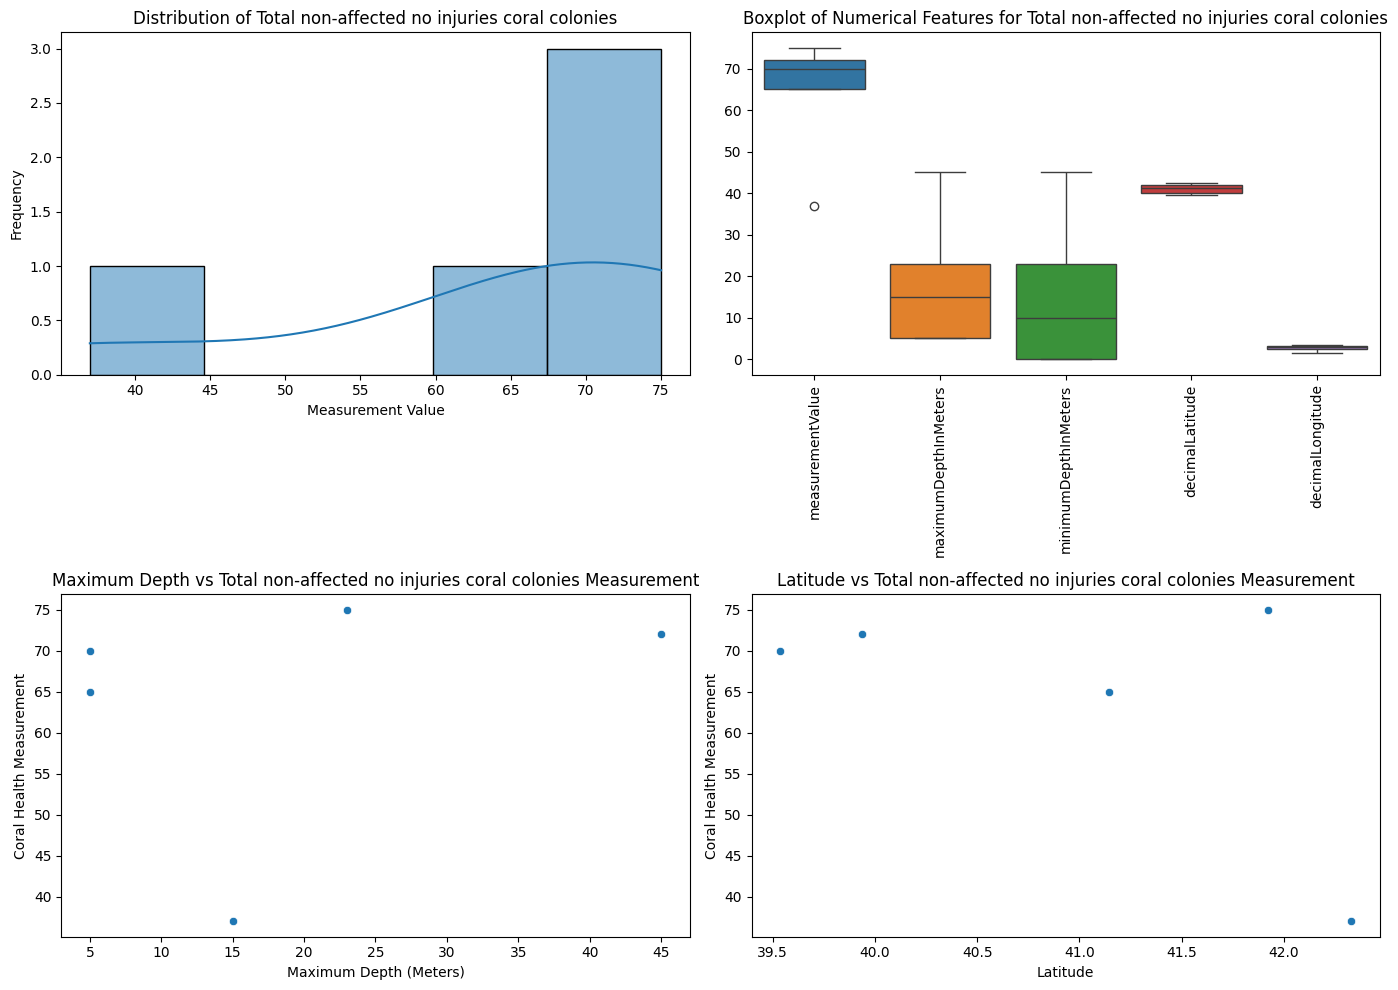

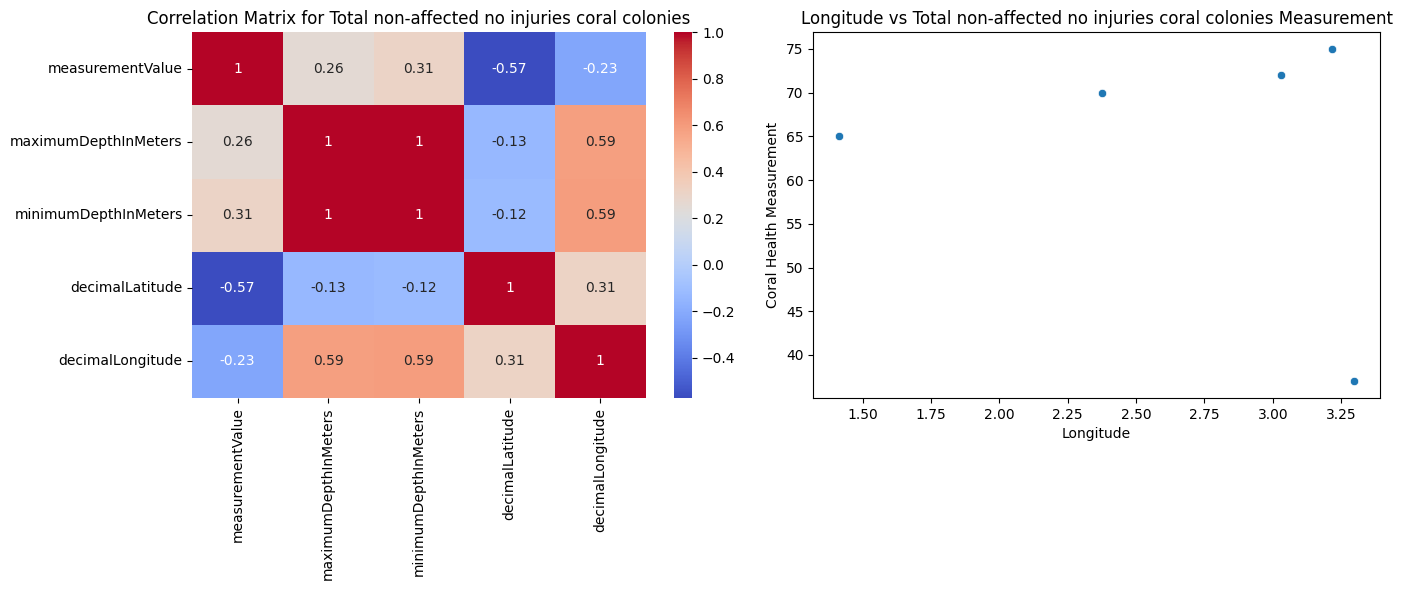

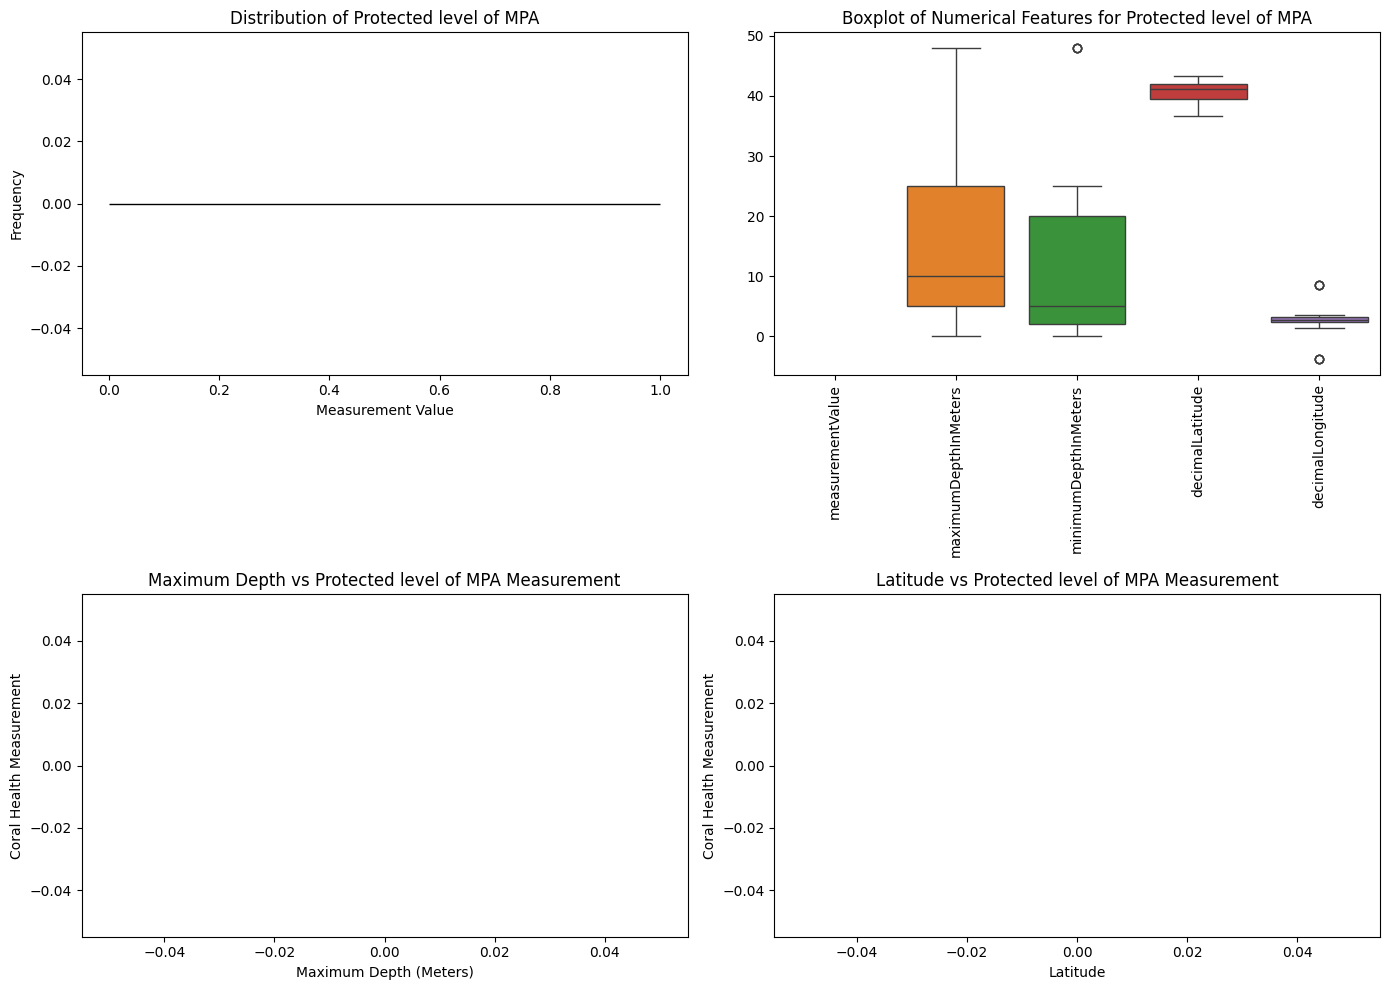

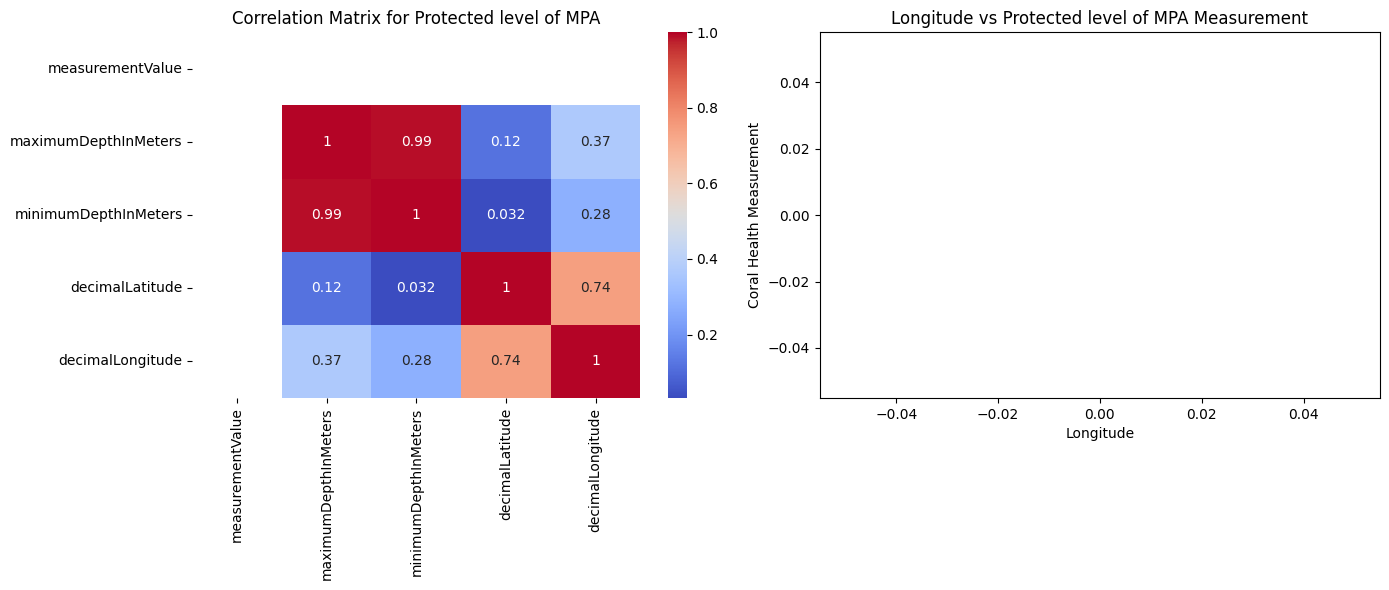

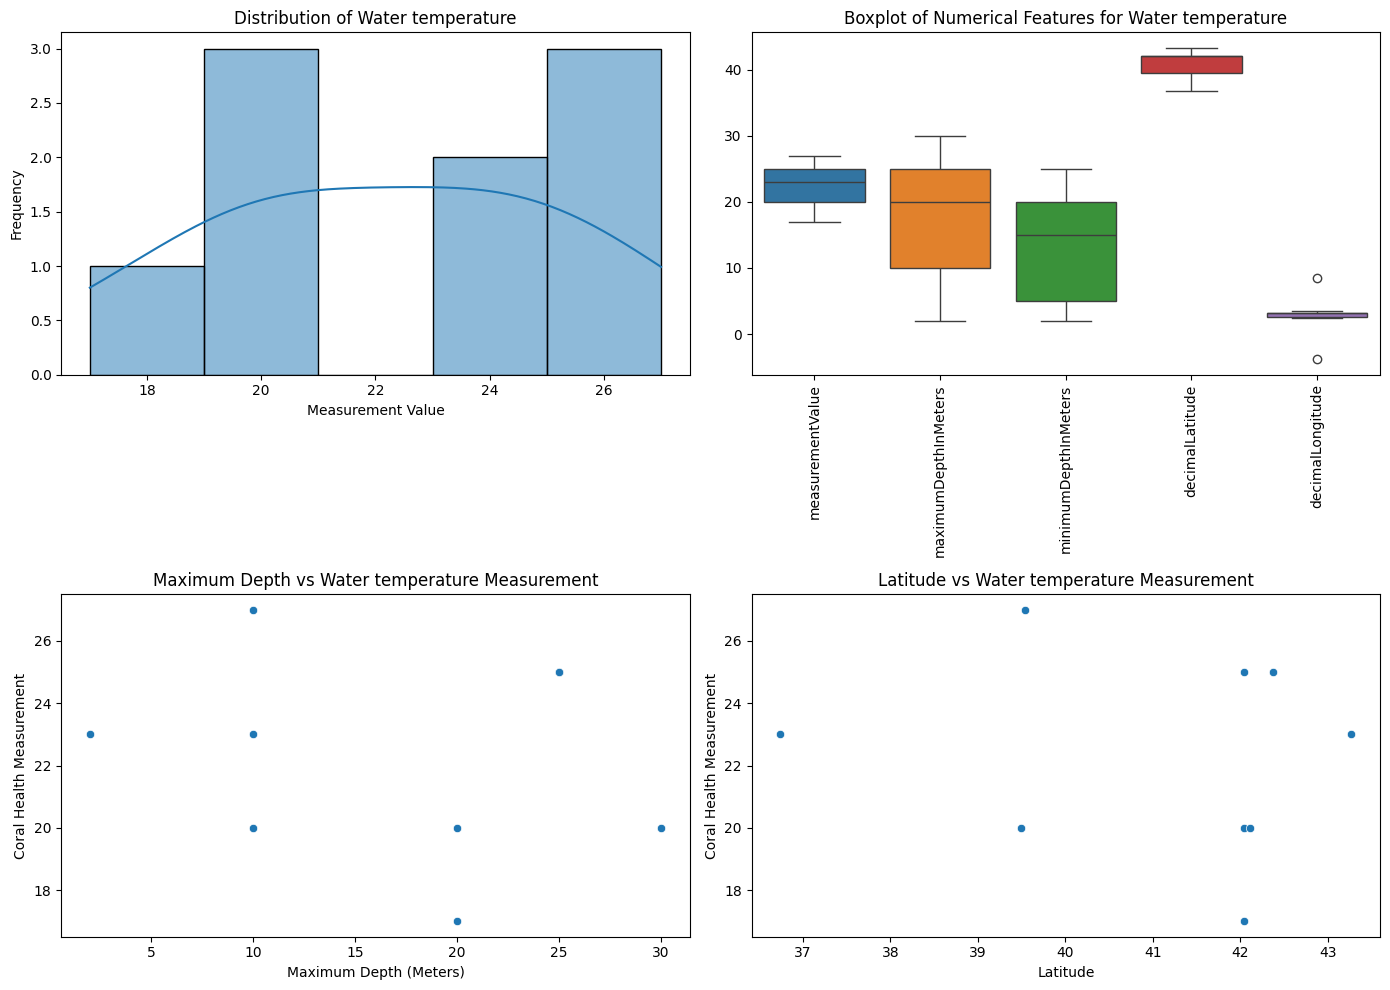

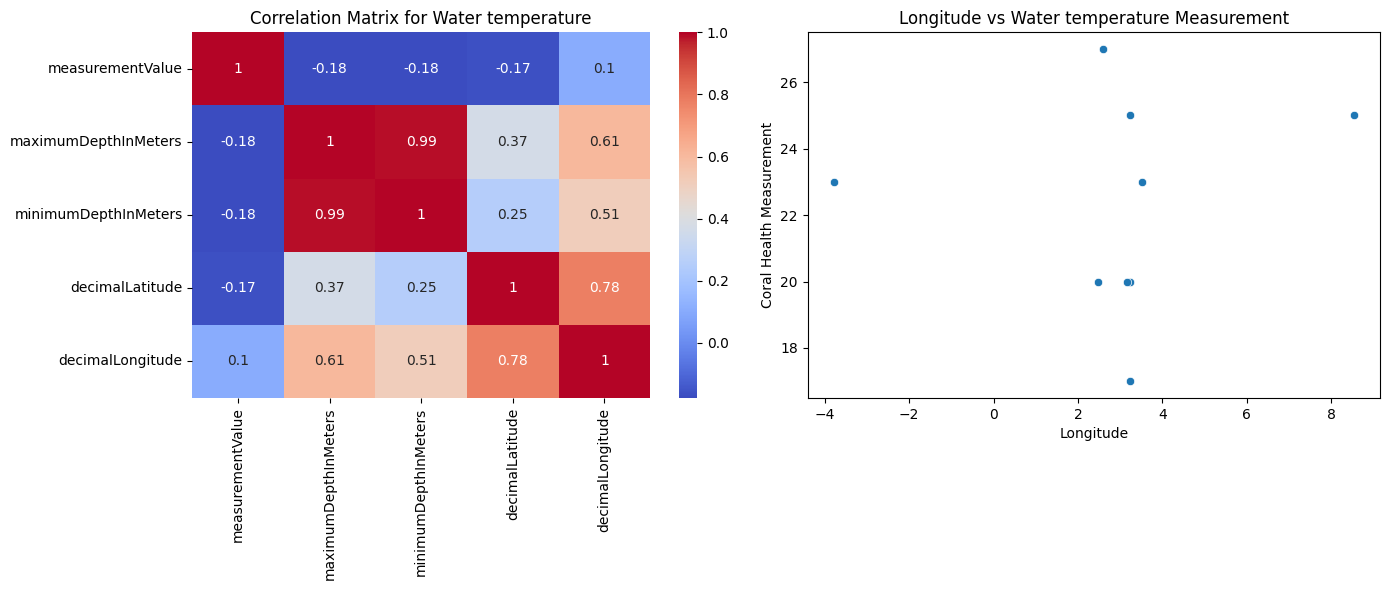

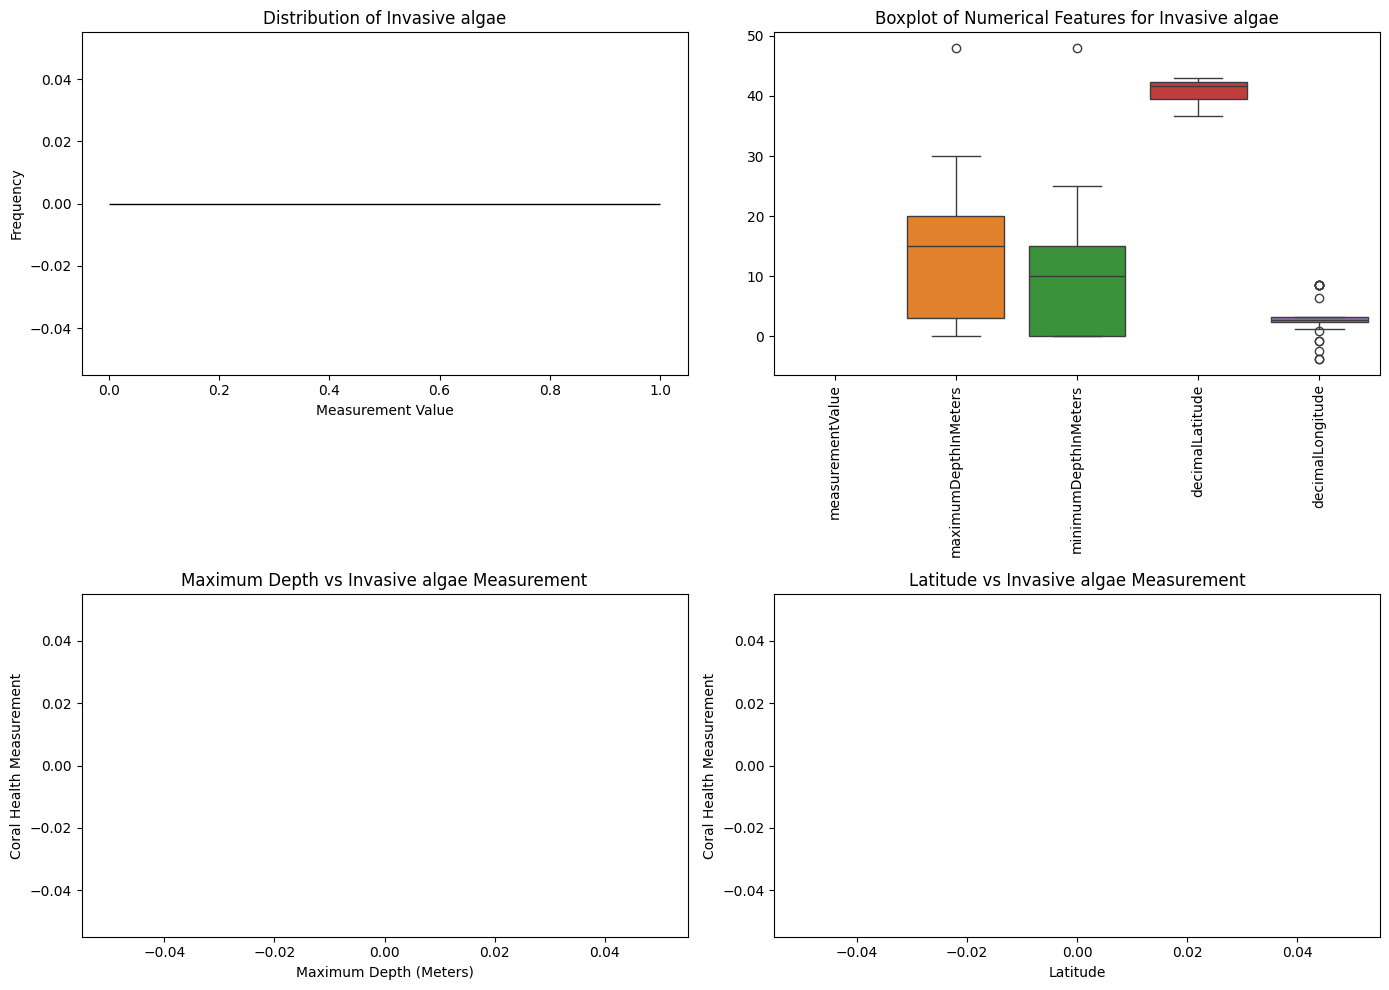

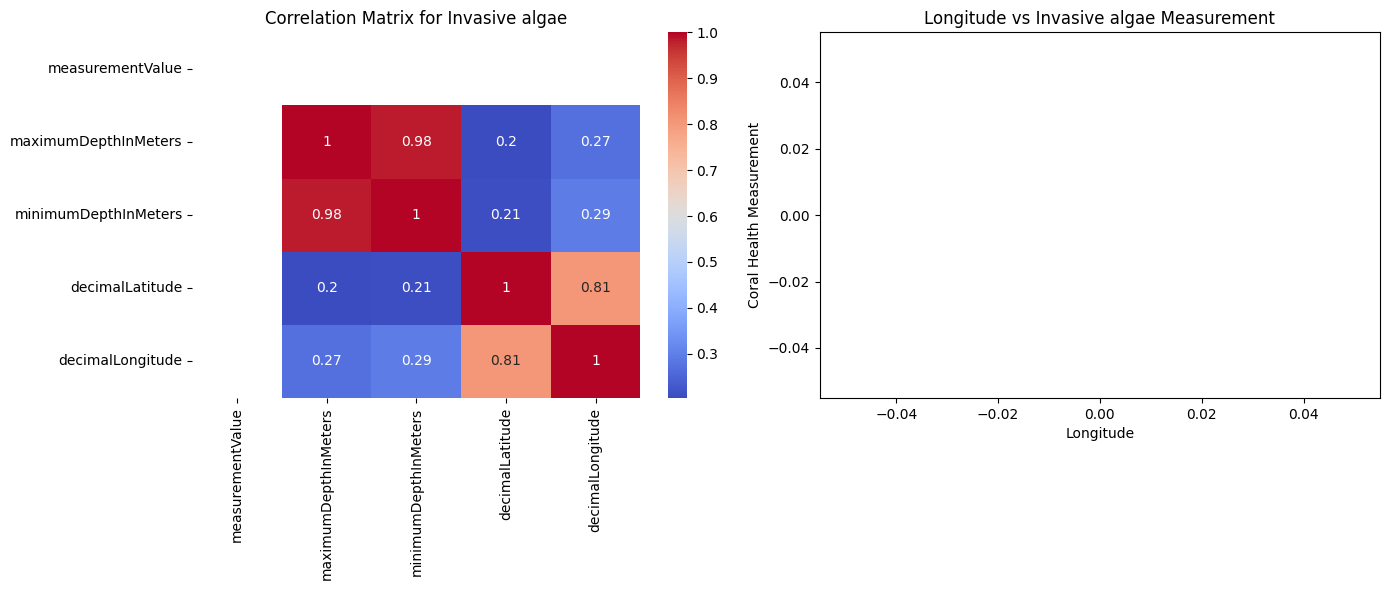

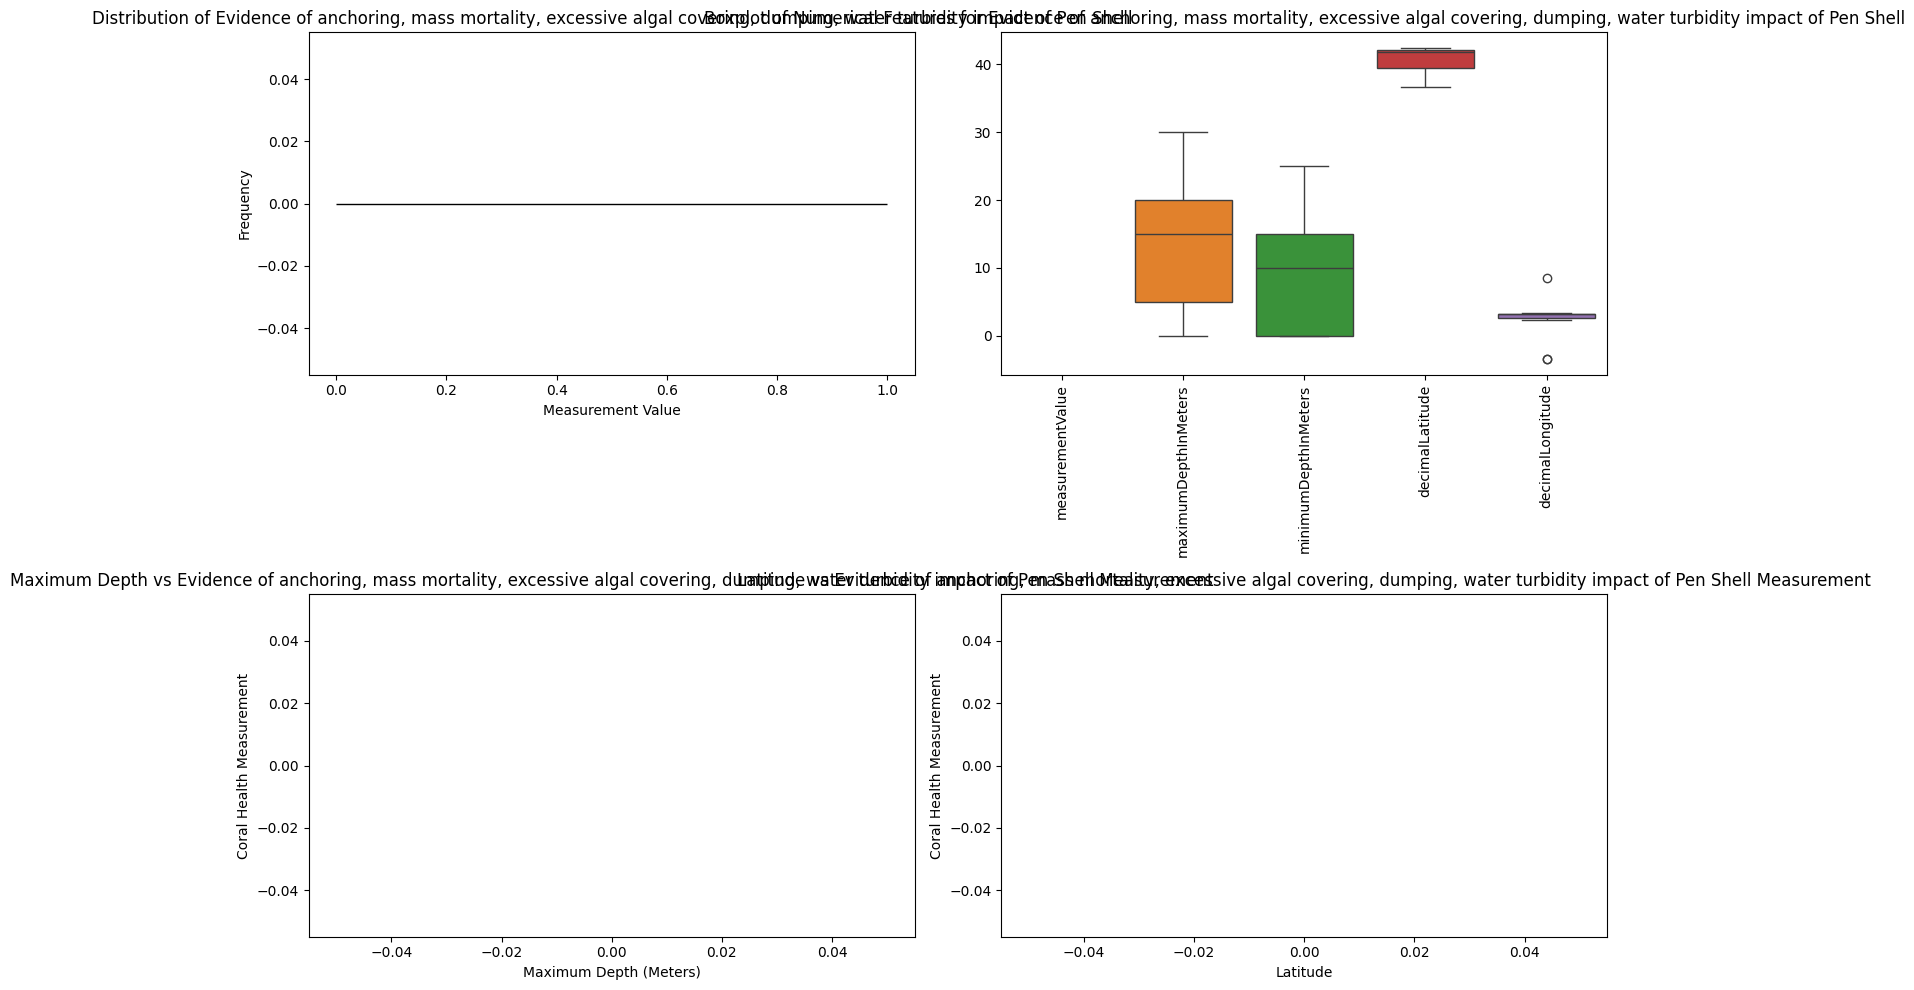

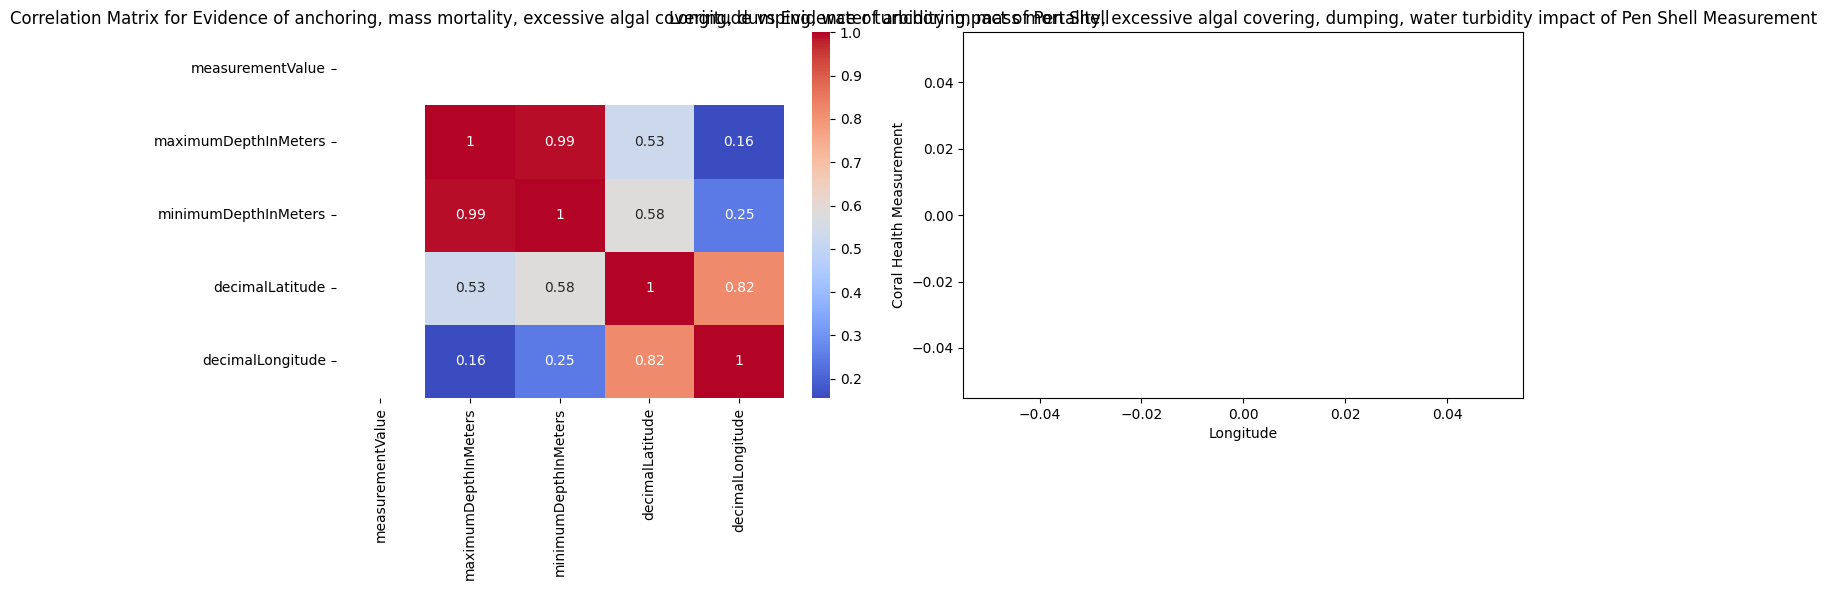

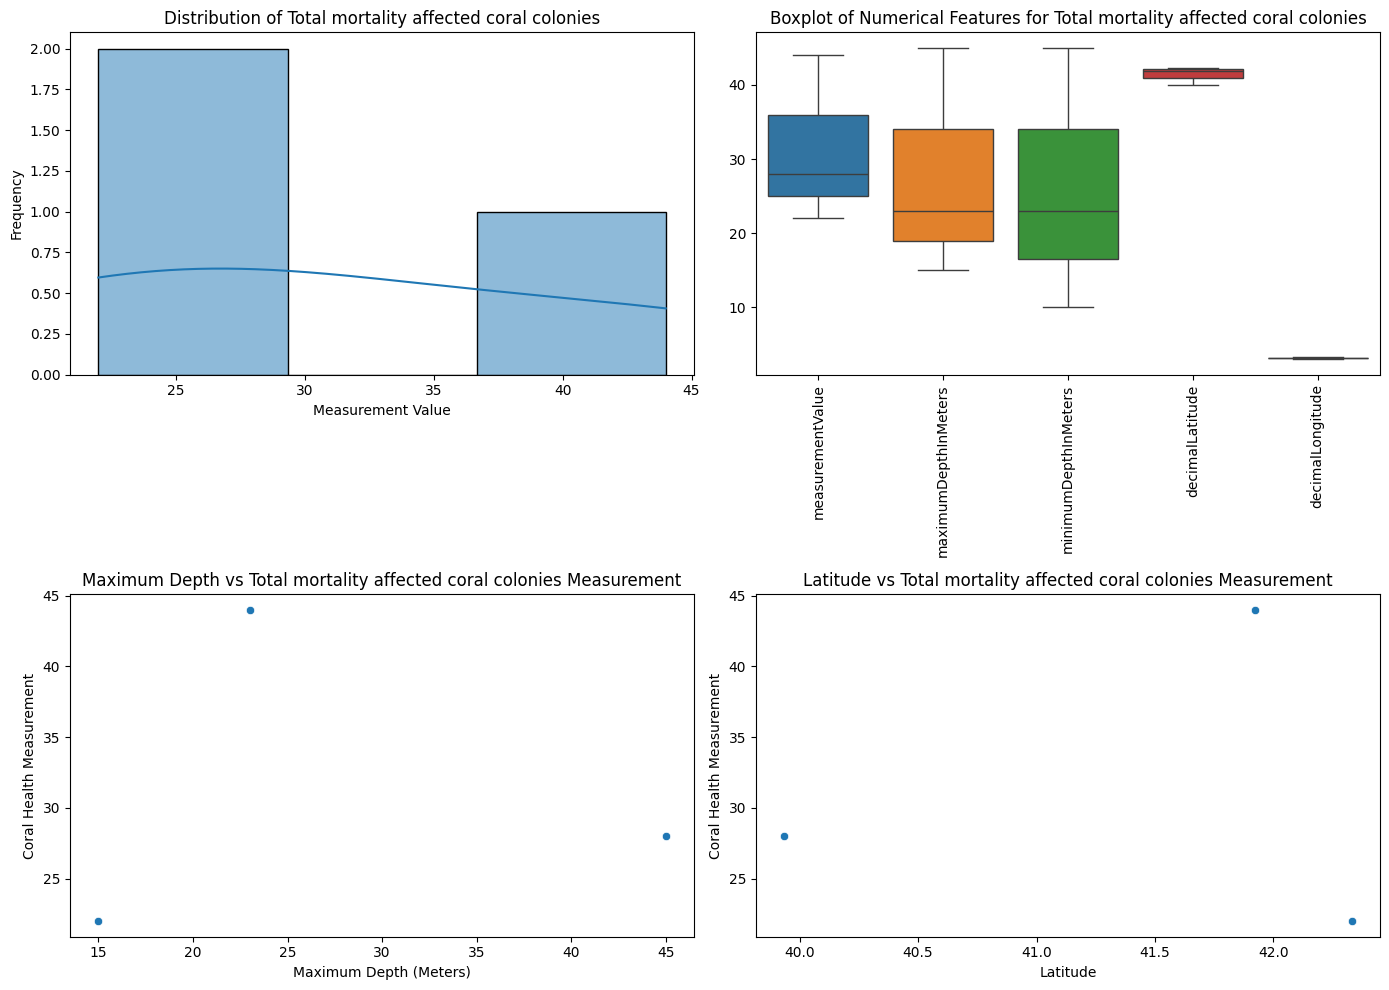

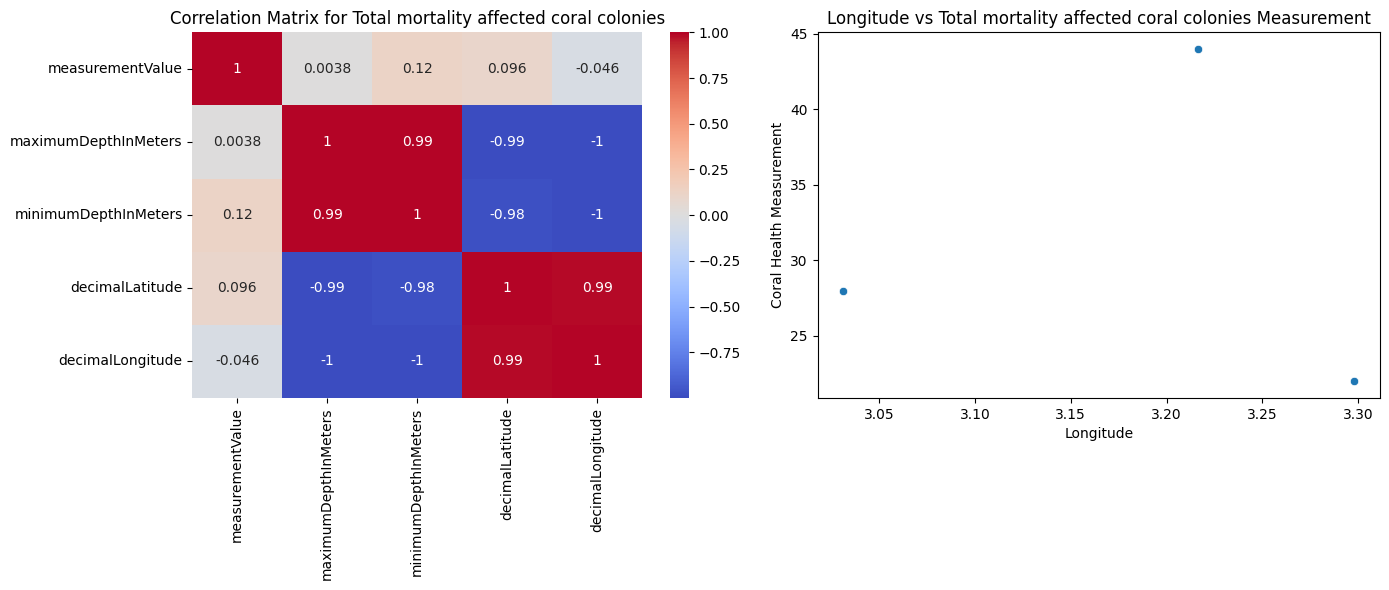

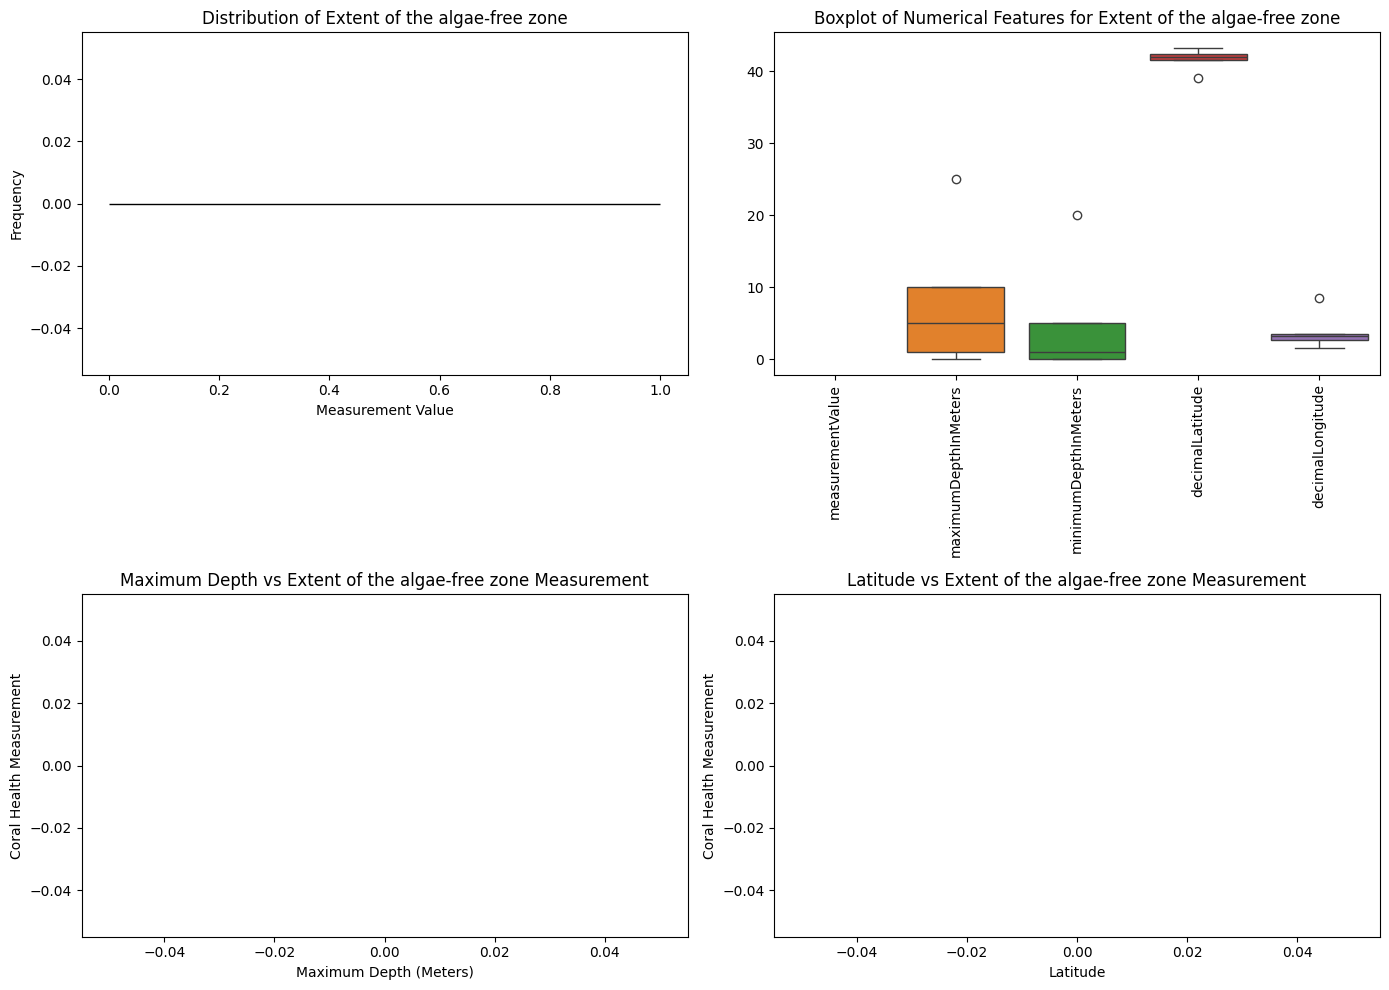

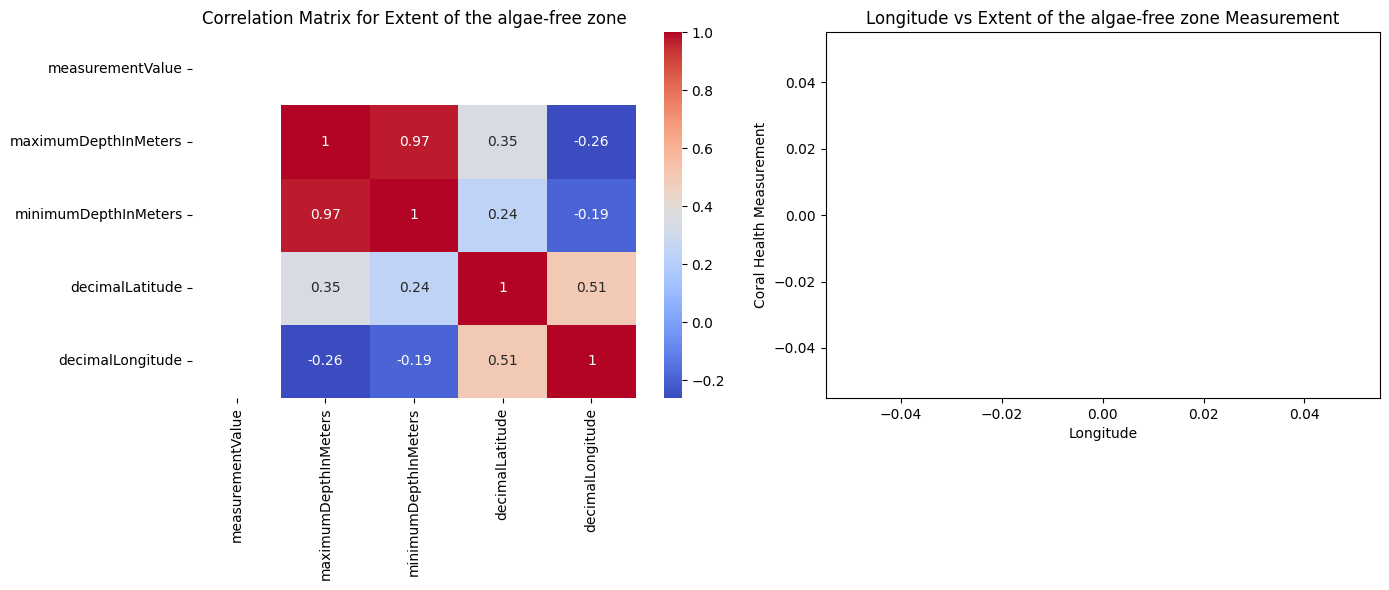

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
file_path = r'C:\Users\ANISH\Desktop\cleaned_coral_health_dataset_12.xlsx'
df = pd.read_excel(file_path)

# Set plot size
plt.rcParams['figure.figsize'] = [14, 10]

# Get unique measurement types
measurement_types = df['measurementType'].unique()

# Loop through each measurement type and perform EDA
for mtype in measurement_types:
    # Filter the dataset for the current measurement type
    filtered_df = df[df['measurementType'] == mtype]
    
    # Create a figure with subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(2, 2)
    
    # Step 1: Distribution of measurement values
    sns.histplot(filtered_df['measurementValue'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Distribution of {mtype}')
    axes[0, 0].set_xlabel('Measurement Value')
    axes[0, 0].set_ylabel('Frequency')

    # Step 2: Boxplot of relevant numerical features
    sns.boxplot(data=filtered_df[['measurementValue', 'maximumDepthInMeters', 'minimumDepthInMeters', 'decimalLatitude', 'decimalLongitude']], ax=axes[0, 1])
    axes[0, 1].set_title(f'Boxplot of Numerical Features for {mtype}')
    
    # Set xticklabels rotation
    plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=90)

    # Step 3: Scatterplot of depth vs measurementValue
    sns.scatterplot(x='maximumDepthInMeters', y='measurementValue', data=filtered_df, ax=axes[1, 0])
    axes[1, 0].set_title(f'Maximum Depth vs {mtype} Measurement')
    axes[1, 0].set_xlabel('Maximum Depth (Meters)')
    axes[1, 0].set_ylabel('Coral Health Measurement')

    # Step 4: Scatterplot for latitude vs coral health measurement
    sns.scatterplot(x='decimalLatitude', y='measurementValue', data=filtered_df, ax=axes[1, 1])
    axes[1, 1].set_title(f'Latitude vs {mtype} Measurement')
    axes[1, 1].set_xlabel('Latitude')
    axes[1, 1].set_ylabel('Coral Health Measurement')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    # Create another figure for correlation and longitude scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Step 5: Correlation matrix
    corr = filtered_df[['measurementValue', 'maximumDepthInMeters', 'minimumDepthInMeters', 'decimalLatitude', 'decimalLongitude']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[0])
    axes[0].set_title(f'Correlation Matrix for {mtype}')

    # Step 6: Scatterplot for longitude vs coral health measurement
    sns.scatterplot(x='decimalLongitude', y='measurementValue', data=filtered_df, ax=axes[1])
    axes[1].set_title(f'Longitude vs {mtype} Measurement')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Coral Health Measurement')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


Water Temperature ANOVA Results: F-value = 19.76, p-value = 0.0023
Water Temperature T-test Results: t-statistic = -5.05, p-value = 0.0016


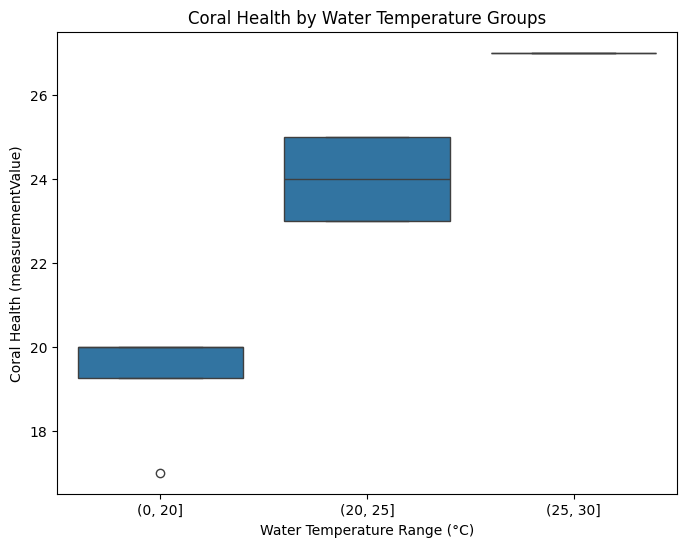

Total Mortality ANOVA Results: F-value = nan, p-value = nan
Total Mortality T-test Results: t-statistic = nan, p-value = nan


c:\Users\ANISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4141: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(stats.DegenerateDataWarning(msg))
c:\Users\ANISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\ANISH\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


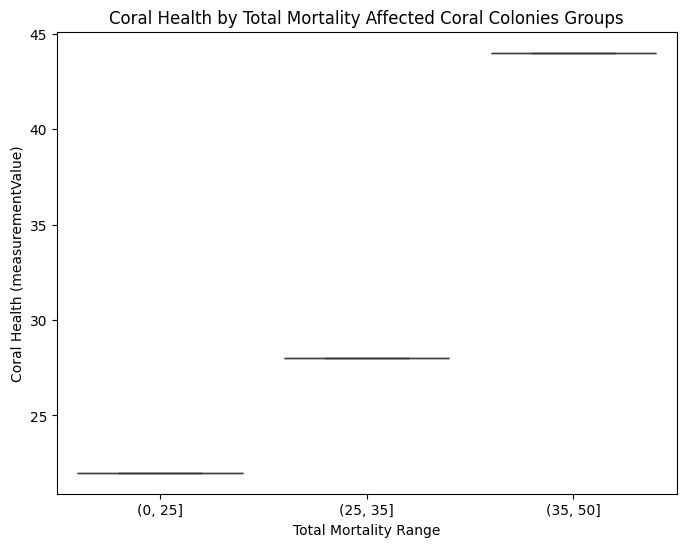

In [6]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'C:\Users\ANISH\Desktop\cleaned_coral_health_dataset_12.xlsx'
cleaned_data = pd.read_excel(file_path)

# Step 1: Filter out rows with missing measurementValue
cleaned_data_filtered = cleaned_data.dropna(subset=['measurementValue'])

# Step 2: Focus on Water Temperature and Total Mortality Affected Coral Colonies
#  will perform statistical tests on the "Water temperature" and "Total mortality affected coral colonies"

# Filter data for Water Temperature
water_temperature_data = cleaned_data_filtered[cleaned_data_filtered['measurementType'] == 'Water temperature']

# Step 2: Perform one-way ANOVA on Water Temperature groups (binning temperature into groups)

anova_results_temp = stats.f_oneway(
    water_temperature_data[water_temperature_data['measurementValue'] <= 20]['measurementValue'],
    water_temperature_data[(water_temperature_data['measurementValue'] > 20) & (water_temperature_data['measurementValue'] <= 25)]['measurementValue'],
    water_temperature_data[water_temperature_data['measurementValue'] > 25]['measurementValue']
)

# Step 3: Perform T-test for temperature groups (<=20°C and >20°C)

t_test_results_temp = stats.ttest_ind(
    water_temperature_data[water_temperature_data['measurementValue'] <= 20]['measurementValue'],
    water_temperature_data[water_temperature_data['measurementValue'] > 20]['measurementValue'],
    equal_var=False  # Assume unequal variance
)

# Print the ANOVA and t-test results for Water Temperature

print(f"Water Temperature ANOVA Results: F-value = {anova_results_temp.statistic:.2f}, p-value = {anova_results_temp.pvalue:.4f}")

print(f"Water Temperature T-test Results: t-statistic = {t_test_results_temp.statistic:.2f}, p-value = {t_test_results_temp.pvalue:.4f}")

# Step 4: Boxplot of Coral Health by Temperature Group
plt.figure(figsize=(8, 6))
sns.boxplot(x=pd.cut(water_temperature_data['measurementValue'], bins=[0, 20, 25, 30]), y=water_temperature_data['measurementValue'])
plt.title('Coral Health by Water Temperature Groups')
plt.xlabel('Water Temperature Range (°C)')
plt.ylabel('Coral Health (measurementValue)')
plt.show()

# --- Now Repeat the Process for "Total Mortality Affected Coral Colonies" ---

# Filter data for Total Mortality Affected Coral Colonies
mortality_data = cleaned_data_filtered[cleaned_data_filtered['measurementType'] == 'Total mortality affected coral colonies']

# Step 2: Perform one-way ANOVA on Mortality groups (if applicable, else adjust)

anova_results_mortality = stats.f_oneway(
    mortality_data[mortality_data['measurementValue'] <= 25]['measurementValue'],
    mortality_data[(mortality_data['measurementValue'] > 25) & (mortality_data['measurementValue'] <= 35)]['measurementValue'],
    mortality_data[mortality_data['measurementValue'] > 35]['measurementValue']
)

# Step 3: Perform T-test for mortality groups (<=25 and >25)

t_test_results_mortality = stats.ttest_ind(
    mortality_data[mortality_data['measurementValue'] <= 25]['measurementValue'],
    mortality_data[mortality_data['measurementValue'] > 25]['measurementValue'],
    equal_var=False  # Assume unequal variance
)

# Print the ANOVA and t-test results for Total Mortality Affected Coral Colonies

print(f"Total Mortality ANOVA Results: F-value = {anova_results_mortality.statistic:.2f}, p-value = {anova_results_mortality.pvalue:.4f}")

print(f"Total Mortality T-test Results: t-statistic = {t_test_results_mortality.statistic:.2f}, p-value = {t_test_results_mortality.pvalue:.4f}")

# Step 4: Boxplot of Total Mortality by Group
plt.figure(figsize=(8, 6))
sns.boxplot(x=pd.cut(mortality_data['measurementValue'], bins=[0, 25, 35, 50]), y=mortality_data['measurementValue'])
plt.title('Coral Health by Total Mortality Affected Coral Colonies Groups')
plt.xlabel('Total Mortality Range')
plt.ylabel('Coral Health (measurementValue)')
plt.show()


Water Temperature ANOVA Results: F-value = 19.76, p-value = 0.0023
Water Temperature T-test Results: t-statistic = -5.05, p-value = 0.0016


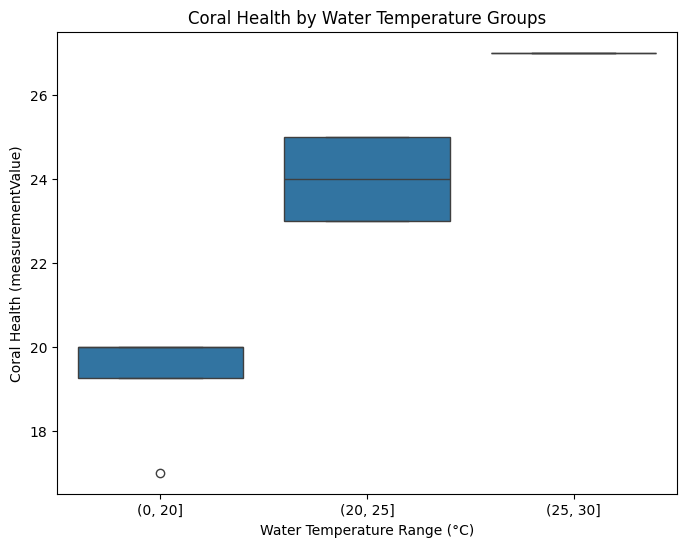

Filtered Water Temperature data saved to 'C:\Users\ANISH\Desktop\filtered_water_temperature_data.xlsx'


In [7]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r'C:\Users\ANISH\Desktop\cleaned_coral_health_dataset_12.xlsx'
cleaned_data = pd.read_excel(file_path)

# Step 1: Focus only on "Water Temperature" and discard other measurement types
water_temperature_data = cleaned_data[cleaned_data['measurementType'] == 'Water temperature']

# Step 2: Filter out rows with missing measurementValue
water_temperature_data = water_temperature_data.dropna(subset=['measurementValue'])

# Step 3: Perform one-way ANOVA on Water Temperature groups (binning temperature into groups)
anova_results_temp = stats.f_oneway(
    water_temperature_data[water_temperature_data['measurementValue'] <= 20]['measurementValue'],
    water_temperature_data[(water_temperature_data['measurementValue'] > 20) & (water_temperature_data['measurementValue'] <= 25)]['measurementValue'],
    water_temperature_data[water_temperature_data['measurementValue'] > 25]['measurementValue']
)

# Step 4: Perform T-test for temperature groups (<=20°C and >20°C)
t_test_results_temp = stats.ttest_ind(
    water_temperature_data[water_temperature_data['measurementValue'] <= 20]['measurementValue'],
    water_temperature_data[water_temperature_data['measurementValue'] > 20]['measurementValue'],
    equal_var=False  # Assume unequal variance
)

# Print the ANOVA and T-test results for Water Temperature
print(f"Water Temperature ANOVA Results: F-value = {anova_results_temp.statistic:.2f}, p-value = {anova_results_temp.pvalue:.4f}")
print(f"Water Temperature T-test Results: t-statistic = {t_test_results_temp.statistic:.2f}, p-value = {t_test_results_temp.pvalue:.4f}")

# Step 5: Boxplot of Coral Health by Temperature Group
plt.figure(figsize=(8, 6))
sns.boxplot(x=pd.cut(water_temperature_data['measurementValue'], bins=[0, 20, 25, 30]), y=water_temperature_data['measurementValue'])
plt.title('Coral Health by Water Temperature Groups')
plt.xlabel('Water Temperature Range (°C)')
plt.ylabel('Coral Health (measurementValue)')
plt.show()

# save the filtered Water Temperature data for future use:
output_file_path = r'C:\Users\ANISH\Desktop\filtered_water_temperature_data.xlsx'
water_temperature_data.to_excel(output_file_path, index=False)

print(f"Filtered Water Temperature data saved to '{output_file_path}'")


In [8]:
import pandas as pd

# Load the cleaned dataset
file_path = r'C:\Users\ANISH\Desktop\cleaned_coral_health_dataset_12.xlsx'
cleaned_data = pd.read_excel(file_path)

# Step 1: Create Binned Water Temperature Feature
# Define bins and labels for water temperature categories

bins = [0, 20, 25, 30]
labels = ['Cold (<=20°C)', 'Moderate (20-25°C)', 'Warm (>25°C)']
cleaned_data['temp_category'] = pd.cut(cleaned_data['measurementValue'], bins=bins, labels=labels, include_lowest=True)

# Step 2: Create Interaction Feature between Water Temperature and Depth
# For simplicity, use the maximum depth

cleaned_data['temp_depth_interaction'] = cleaned_data['temp_category'].astype(str) + '_Depth_' + cleaned_data['maximumDepthInMeters'].astype(str)

# Step 3: Optional - Create Clusters for Latitude/Longitude if the dataset covers large areas
#  can either skip this if the geographic area is localized or create clusters based on coordinates

# Saving the engineered dataset

output_file_path = r'C:\Users\ANISH\Desktop\engineered_dataset_1.xlsx'
cleaned_data.to_excel(output_file_path, index=False)

print(f"Feature engineering complete. The dataset with new features is saved to '{output_file_path}'.")


Feature engineering complete. The dataset with new features is saved to 'C:\Users\ANISH\Desktop\engineered_dataset_1.xlsx'.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Load the engineered dataset
file_path = r'C:\Users\ANISH\Desktop\engineered_dataset_1.xlsx'
data = pd.read_excel(file_path)

# Step 2: Define features and target variable
# Assume 'measurementValue' is the target variable (coral health) and other columns are features

features = ['maximumDepthInMeters', 'minimumDepthInMeters', 'decimalLatitude', 'decimalLongitude', 'temp_category']  #  can add other engineered features
X = pd.get_dummies(data[features], drop_first=True)  # Convert categorical features to dummy variables
y = data['measurementValue']

# Step 3: Remove rows where the target variable contains NaN values
# Drop rows with NaN values in the target variable
X = X[~y.isna()]
y = y.dropna()

# Step 4: Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model building - Random Forest and Gradient Boosting
# Initialize the models

rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Step 6: Cross-validation to evaluate models

rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2')

print(f"Random Forest Cross-Validation R-squared scores: {rf_cv_scores.mean():.4f}")
print(f"Gradient Boosting Cross-Validation R-squared scores: {gb_cv_scores.mean():.4f}")

# Step 7: Train and evaluate the Random Forest model

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model evaluation metrics for Random Forest

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Model Performance on Test Set:")
print(f"MAE: {rf_mae:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R-squared: {rf_r2:.4f}")

# Step 8: Train and evaluate the Gradient Boosting model

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Model evaluation metrics for Gradient Boosting

gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"\nGradient Boosting Model Performance on Test Set:")
print(f"MAE: {gb_mae:.4f}")
print(f"RMSE: {gb_rmse:.4f}")
print(f"R-squared: {gb_r2:.4f}")


Random Forest Cross-Validation R-squared scores: -61.5992
Gradient Boosting Cross-Validation R-squared scores: -50.6580

Random Forest Model Performance on Test Set:
MAE: 9.9620
RMSE: 10.4051
R-squared: 0.6625

Gradient Boosting Model Performance on Test Set:
MAE: 6.2664
RMSE: 8.7515
R-squared: 0.7612


In [10]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Tuning Random Forest
grid_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")

# Tuning Gradient Boosting
grid_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)
print(f"Best parameters for Gradient Boosting: {grid_gb.best_params_}")


Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}


In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Train Random Forest with the best parameters
rf_best = RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)

# Evaluate Random Forest with the best parameters
rf_best_mae = mean_absolute_error(y_test, y_pred_rf_best)
rf_best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
rf_best_r2 = r2_score(y_test, y_pred_rf_best)

print(f"\nRandom Forest (Best Parameters) Performance on Test Set:")
print(f"MAE: {rf_best_mae:.4f}")
print(f"RMSE: {rf_best_rmse:.4f}")
print(f"R-squared: {rf_best_r2:.4f}")

# Step 2: Train Gradient Boosting with the best parameters
gb_best = GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=100, random_state=42)
gb_best.fit(X_train, y_train)
y_pred_gb_best = gb_best.predict(X_test)

# Evaluate Gradient Boosting with the best parameters
gb_best_mae = mean_absolute_error(y_test, y_pred_gb_best)
gb_best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb_best))
gb_best_r2 = r2_score(y_test, y_pred_gb_best)

print(f"\nGradient Boosting (Best Parameters) Performance on Test Set:")
print(f"MAE: {gb_best_mae:.4f}")
print(f"RMSE: {gb_best_rmse:.4f}")
print(f"R-squared: {gb_best_r2:.4f}")



Random Forest (Best Parameters) Performance on Test Set:
MAE: 14.5098
RMSE: 17.0269
R-squared: 0.0961

Gradient Boosting (Best Parameters) Performance on Test Set:
MAE: 8.5067
RMSE: 8.9440
R-squared: 0.7506


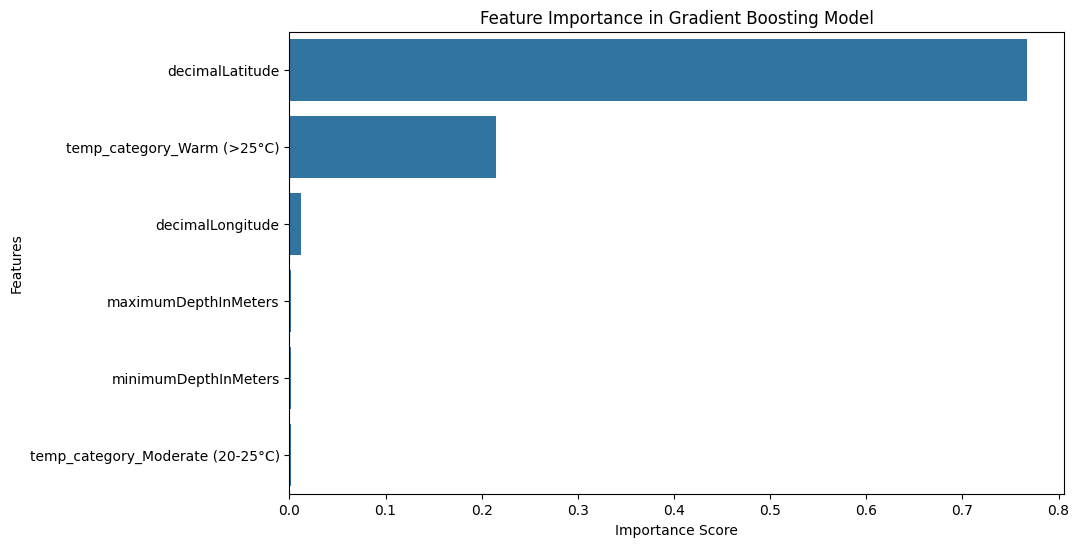

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from the best Gradient Boosting model
feature_importance = pd.Series(gb_best.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance in Gradient Boosting Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
